In [1]:
from polychrom import forcekits, forces, starting_conformations, simulation
from polychrom.hdf5_format import HDF5Reporter
import numpy as np
import openmm as mm
from dataclasses import dataclass
from math import pi
from typing import Dict, List, Tuple, TypedDict, Any
import pickle
import numpy as np


In [2]:
from poly_shared import (
    MoleculeStructure,
    Bond,
    Angle,
    Dihedral,
    dihedral_angle,
    verify_bond_angle_dihedral_uniqeness,
    concatenate_molecule_structures,
    build_ribbon,
    connect_ribbon_ends,
    connect_with_polymer,
    add_polymer_forces,
)


In [4]:
USE_TWIST_DIHEDRALS = True  # whether to use dihedrals to stabilize the twisting of ribbons at the connection

extra_bonds: list[Bond] = []
extra_angles: list[Angle] = []
extra_dihedrals: list[Dihedral] = []


extra_kw = {"extra_bonds": extra_bonds, "extra_angles": extra_angles, "extra_dihedrals": extra_dihedrals}

l_till_break = 14
n_rows = 28

shared_kwargs: dict[str, Any] = {
    "right_angle_k": 100.0,
    "backbone_angle_k": 150.0,
    "dihedral_k": 100.0,
    "n_rows": n_rows,
    "break_idx": n_rows - l_till_break,
}

d_off = .83

ribbon = build_ribbon(**shared_kwargs, dihedral_offset=d_off, break_sign=1.0)

# connect (10,1) and (16,1) particle of ribbon for visualization purposes
# extra_bonds.append((ribbon.index_dict[(10, 1)], ribbon.index_dict[(16, 1)], 5, 1000))

# actually pull the first ribbon's start/end apart
# extra_bonds.append((ribbon.start_particle_index, ribbon.get_end_idx(), 0, 2.0))

st_idx = ribbon.get_next_idx()
ribbon2 = build_ribbon(
    start=(0, 3, 0), start_particle_index=st_idx, dihedral_offset=-d_off, break_sign=-1.0, **shared_kwargs
)

# connect start/end of each ribbon with extra weak bond
# extra_bonds.append((ribbon.start_particle_index, ribbon.start_particle_index + len(ribbon.positions) - 1, 5.0, 25.0))
# extra_bonds.append((ribbon2.start_particle_index, ribbon2.start_particle_index + len(ribbon2.positions) - 1, 5.0, 25.0))

connect_ribbon_ends(ribbon, ribbon2, **extra_kw)

# connect ribbon starts with a fixed bond, and make it perpendicular to the backbone
sp1 = ribbon.start_particle_index
sp2 = ribbon2.start_particle_index
extra_bonds.append((sp1, sp2, 5.0, 0.3))
extra_angles.append((sp2, sp1, sp1 + 2, pi / 2, shared_kwargs["right_angle_k"]))
extra_angles.append((sp1, sp2, sp2 + 2, pi / 2, shared_kwargs["right_angle_k"]))

# stabilize the twisting of ribbons at the connection
twist_angle = 2.1 # empirically obtained typical angle at rest
# record dihedral indices for updating them in the future
dih1 = (sp1, sp2, sp2 + 2, sp2 + 2 + 1)
dih2 = (sp2, sp1, sp1 + 2, sp1 + 2 + 1)
if USE_TWIST_DIHEDRALS:
    # add dihedrals to keep the connection square planar
    extra_dihedrals.append((*dih1, -twist_angle, shared_kwargs["dihedral_k"]))
    extra_dihedrals.append((*dih2, twist_angle, shared_kwargs["dihedral_k"]))


# extra_bonds.append((ribbon.start_particle_index+1, ribbon2.start_particle_index+1, 4.0, 0.5))

# connect two connected ends with polymer of length 5
polymer = connect_with_polymer(
    ribbon,
    ribbon.get_end_idx(),
    ribbon2,
    ribbon2.get_end_idx(),
    start_mon_idx=ribbon2.get_next_idx(),
    n_monomers=5,
    extra_bonds=extra_bonds,
)
polymer2 = connect_with_polymer(
    ribbon,
    ribbon.start_particle_index,
    ribbon2,
    ribbon2.start_particle_index,
    start_mon_idx=polymer.get_next_idx(),
    n_monomers=25,
    extra_bonds=extra_bonds,
)


combined_structure = concatenate_molecule_structures(
    [ribbon, ribbon2, polymer, polymer2],
    names=["ribbon", "ribbon2", "polymer", "polymer2"],
)


N = combined_structure.positions.shape[0]
positions = combined_structure.positions

positions = pickle.load(open("folded.pkl", "rb"))  # load scrunched up state from a file

bonds = combined_structure.bonds + extra_bonds
angles = combined_structure.angles + extra_angles
dihedrals = combined_structure.dihedrals + extra_dihedrals

reporter = HDF5Reporter(folder="trajectory", max_data_length=5, overwrite=True)
sim = simulation.Simulation(
    platform="OpenCL",
    integrator="variableLangevin",
    error_tol=0.001,
    GPU="0",
    collision_rate=0.01,
    N=N,
    save_decimals=2,
    PBCbox=False,
    reporters=[reporter],
)


sim.set_data(positions, center=True)  # loads a polymer, puts a center of mass at zero
# Add forces to the simulation
res = add_polymer_forces(sim, bonds, angles, dihedrals)
assert res is not None  # here it won't be None as we have dihedrals
DihedralIndDict, dihedral_force = res
sim.add_force(forces.spherical_confinement(sim, r=30, k=1))
# nonbonded force
rep_force = forces.polynomial_repulsive(sim, trunc=50, radiusMult=1)
sim.add_force(rep_force)
remover = mm.CMMotionRemover()
remover.name = "remover"  # type: ignore - this is polychrom's old convention
sim.add_force(remover)  # add motion remover to remove center of mass motion


# Building the torque-sensing structure near the break point
# break_idx - 3 through break_idx - 2 the dihedral is missing

# particle indices:
# ( break_idx - 3, 0): 1     (break_idx, 0): 7
# ( break_idx - 3, 1): 2     (break_idx, 1): 8
# ( break_idx - 2, 0): 3     (break_idx + 1, 0): 9
# ( break_idx - 2, 1): 4     (break_idx + 1 , 1): 10
# ( break_idx - 1, 0): 5
# ( break_idx - 1, 1): 6


# alpha 5/3pi is the "straight line" dihedral for cos(dihedral(p6, p8, p7, p10) - alpha))
# alpha = 2/3 pi is the "Fully scrunched" angle


# The torque-sensing part will be simple dihedral between two edges extending from the backbone.

if True:
    # --- build the CustomCompoundBondForce with “energy first” ----------------
    expr = """
    // 11) Total energy = hinge-driving + penalty
    E_hinge + E_pen;

    // 10) Hinge-driving part (two dihedrals toward the same target)
    E_hinge   = k*(1 - cos(phi_h1 - theta_tgt))
            + k*(1 - cos(phi_h2 - theta_tgt));
    //E_hinge   = k*(1 - cos(phi_h1 - 9 * pi / 6))
    //        + k*(1 - cos(phi_h2 - 9 * pi / 6));
    // 9) Quadratic wall outside the free torsion window |phi_scaled| <= 1
    E_pen     = k*2 * step(delta) * delta*delta;

    // 8) How far outside the window?  delta = abs(phi_scaled) - 1
    delta     = abs(phi_scaled) - 1;

    // 7) Two hinge dihedrals you want to drive
    phi_h1    = dihedral(p6,p8,p7,p10) * break_sign;
    phi_h2    = dihedral(p5,p8,p7,p9) * break_sign;

    // 6) Target hinge angle in [2*pi/3,5*pi/3]
    theta_tgt = 7*pi/6 + (pi/2 + .15)*phi_clamp_sign;

    // 5) Multiply clamped value by coupling_sign to set direction
    phi_clamp_sign = phi_clamp * coupling_sign;

    // 4) Clamp the normalized torque phi_scaled into [-1,1]
    phi_clamp = max(-1, min(1, phi_scaled));

    // 3) Normalize the torque-sensor dihedral by X
    phi_scaled = phi_ts / X;

    // 2) Torque-sensor dihedral (free window |phi_ts| <= X)
    phi_ts    = dihedral(p2,p1,p3,p4);

    // 1) Constants  - more X means more free rotation
    X         = 1; 
    pi        = 3.141592653589793;
    """
    # remove lines not containing "//"
    expr = "\n".join(line for line in expr.splitlines() if not "//" in line).strip()


    fuckingComplicatedForce = mm.CustomCompoundBondForce(10, expr)
    fuckingComplicatedForce.name = "fuckingComplicatedForce"  # type: ignore - this is polychrom's old convention
    fuckingComplicatedForce.addGlobalParameter("k", 200 * sim.kT)

    # add the 10 particles in the same order you already have them:
    fuckingComplicatedForce.addPerBondParameter("coupling_sign")
    fuckingComplicatedForce.addPerBondParameter("break_sign")

    break_idx = shared_kwargs["break_idx"]
    for ribbon_use, cpl_sign, brk_sign in ((ribbon, 1, 1),(ribbon2, -1, -1)):
        # add particles in the order they are used in the expression

        particles = [ribbon_use.index_dict[(i, j)] for i in range(break_idx - 3, break_idx + 2) for j in (0, 1)]
        print(particles)
        fuckingComplicatedForce.addBond(particles, [cpl_sign, brk_sign])

    sim.add_force(fuckingComplicatedForce)


sim.eK_critical = 1000

sim.local_energy_minimization()
sim.local_energy_minimization()
sim.local_energy_minimization()

all_dh = []
for block in range(200):
    sim.do_block(
        1 if block == 0 else 1000, save_extras={"bonds": bonds}
    )  # Of 100 timesteps each. Data is saved automatically.
    pos = sim.get_data()
    dh1 = dihedral_angle(pos, sp1, sp2, sp2 + 2, sp2 + 2 + 1)
    dh2 = dihedral_angle(pos, sp2, sp1, sp1 + 2, sp1 + 2 + 1)
    dist = np.sum((pos[ribbon.start_particle_index] - pos[ribbon.get_end_idx()]) ** 2)
    # print(f"Block {block}: dihedral angles {dh1:.2f}, {dh2:.2f}, distance {dist:.2f}")
    all_dh.append((dh1, dh2, dist))
    # update the dihedrals to induce torsion in the cohesin
    if USE_TWIST_DIHEDRALS:
        twist_angle -= 0.015
        ind1 = DihedralIndDict[dih1]
        ind2 = DihedralIndDict[dih2]
        dihedral_force.setTorsionParameters(ind1, *dih1, (-twist_angle, shared_kwargs["dihedral_k"]))
        dihedral_force.setTorsionParameters(ind2, *dih2, (twist_angle, shared_kwargs["dihedral_k"]))
        dihedral_force.updateParametersInContext(sim.context)  # update the parameters in the context


sim.print_stats()  # In the end, print very simple statistics

reporter.dump_data()  # always need to run in the end to dump the block cache to the disk

INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force dihedral_force 2
INFO:root:adding force spherical_confinement 3
INFO:root:adding force polynomial_repulsive 4
INFO:root:adding force remover 5
INFO:root:adding force fuckingComplicatedForce 6


[22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[78, 79, 80, 81, 82, 83, 84, 85, 86, 87]


INFO:root:Particles loaded. Potential energy is 69.826003
INFO:root:before minimization eK=1.5289224799352865, eP=69.82600251978201, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 3.717578
INFO:root:after minimization eK=1.5289224799352865, eP=2.985769437057257, time=0.0 ps
INFO:root:Performing local energy minimization
INFO:root:before minimization eK=1.5289224799352865, eP=3.717578189701773, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 3.899983
INFO:root:after minimization eK=1.5289224799352865, eP=2.9857026198863936, time=0.0 ps
INFO:root:Performing local energy minimization
INFO:root:before minimization eK=1.5289224799352865, eP=3.8999830780286455, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 3.639007
INFO:root:after minimization eK=1.5289224799352865, eP=2.7145431178648147, time=0.0 ps
INFO:root:block    0 pos[1]=[1.1 -4.9 2.9] dr=0.01 t=0.0ps kin=1.65 pot=3.52 Rg=5.317 SPS=483 dt=22.0fs dx=6.33pm 
INFO:root:block    1 pos[1]=[0.4 -5.2 3.

KeyboardInterrupt: 

In [184]:
# data = sim.get_data() 
# pickle.dump(data, open("scrunched.pkl", "wb"))  # save the data to a file

In [329]:
dh = np.array(all_dh)
np.mean(dh, axis=0)  # mean dihedral angles

array([ -1.1177714,   1.0653477, 254.69095  ], dtype=float32)

/var/folders/k4/87l5bsb52hd3_hjmy15klwch0000gn/T/ipykernel_73769/2082252021.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(dh[:, 0], dh[:, 2], s=1,  cmap="viridis")


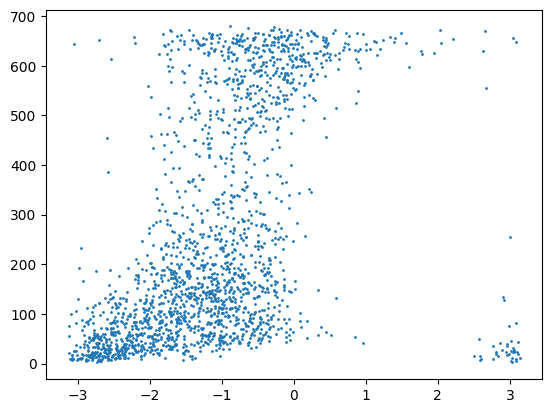

In [330]:

import matplotlib.pyplot as plt
plt.figure() 
plt.scatter(dh[:, 0], dh[:, 2], s=1,  cmap="viridis")